In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import summary
from numpyro.infer import HMC, NUTS, MCMC


# --------------------
# Hyperparameters
# --------------------
SEED = 0
JAX_ENABLE_X64 = True
MC_METHOD = "NUTS"

N = 10  # number of latent variables x_i (and observations y_i)

NUM_WARMUP = 5000
NUM_SAMPLES = 1000
NUM_CHAINS = 2

HMC_NUM_STEPS = 20
HMC_TARGET_ACCEPT_PROB = 0.8

# Prior + likelihood
X_LOW = -5.0
X_HIGH = 5.0
NOISE_SIGMA = 1.0  # data: y = x + Normal(0, 1)

# Global-parameter sine prior for x_i:
#   A ~ HalfNormal(AMP_PRIOR_SCALE)
#   x_i | A ~ Normal(A * sin(2*pi*i/N), X_PRIOR_SIGMA)
AMP_PRIOR_SCALE = 5.0
X_PRIOR_SIGMA = 2

# Synthetic data truth: (x_true exactly on a sine wave)
TRUE_AMP = 4.0

# Diagnostics/plots
PAIR_IDXS = (0, 5, 9)  # which x_i to contour/pair

## Forward model

Let $A$ be a global parameter, $x_{0:N-1}$ latent signal values, and $y_{0:N-1}$ the observed data.

- **Prior (global + latent field)**:
$$
A \sim \mathrm{HalfNormal}(s_A),
\qquad
\mu_i(A)=A\sin\!\left(2\pi \frac{i}{N}\right),
\qquad
x_i\mid A \sim \mathcal{N}(\mu_i(A), \sigma_x)
$$

- **Forward/likelihood (data model)**:
$$
y_i \mid x_i \sim \mathcal{N}(x_i,\sigma_y)
$$

- **Posterior**:
$$
p(A,x\mid y)\propto p(A)\prod_{i=0}^{N-1} p(x_i\mid A)\,p(y_i\mid x_i).
$$

## Numpyro jargons

A distribution conceptually returns a **value** $z$ and a **log density** $\log p(z)$. If $z$ is vector-valued, you must decide whether its components are:
- **batch dimensions**: interpreted as *a collection of independent draws* (NumPyro returns a vector of log-probs), or
- **event dimensions**: interpreted as *one multivariate draw* (NumPyro returns a scalar log-prob after summing over those dims).

Formally, for a vector $z\in\mathbb{R}^N$:

- **batch interpretation** (no event dims):
$$
\log p(z) = \big(\log p(z_0), \dots, \log p(z_{N-1})\big) \quad \text{(shape }(N,)\text{)}
$$
- **event interpretation** (`to_event(1)`):
$$
\log p(z) = \sum_{i=0}^{N-1}\log p(z_i) \quad \text{(scalar)}
$$

So **event dims are “summed over” inside `log_prob`**.
- to_event(0): no batch dims are reinterpreted as event dims (i.e. it does nothing).
- to_event(1): the last 1 batch dimension becomes an event dimension.
- to_event(2): the last 2 batch dimensions become event dims (useful for matrices, images, etc.).


In [2]:
def model(y_obs=None):
    # Global parameter (couples all i)
    A = numpyro.sample("A", dist.HalfNormal(AMP_PRIOR_SCALE))

    # Prior mean is a sine wave in index i
    i = jnp.arange(N)
    mu = A * jnp.sin(2.0 * jnp.pi * i / N)

    # Conditional independence across i given A (and fixed hyperparameters)
    with numpyro.plate("i", N):
        x = numpyro.sample("x", dist.Normal(mu, X_PRIOR_SIGMA))
        numpyro.sample("y_obs", dist.Normal(x, NOISE_SIGMA), obs=y_obs)

    # Alternative 1 (vectorized bounds; also works, returns x shape (N,)):
    # x = numpyro.sample("x", dist.Uniform(jnp.ones(N) * X_LOW, jnp.ones(N) * X_HIGH))
    # numpyro.sample("y_obs", dist.Normal(x, NOISE_SIGMA), obs=y_obs)

    # Alternative 2 (scalar bounds + expand + event-dim; treats x as one vector RV):
    # x = numpyro.sample("x", dist.Uniform(X_LOW, X_HIGH).expand([N]).to_event(1))
    # numpyro.sample("y_obs", dist.Normal(x, NOISE_SIGMA).to_event(1), obs=y_obs)


## Execution

In [3]:
def plot_traces(A_chain, x_chain, filename="hmc_trace.png"):
    # A_chain: (C,S), x_chain: (C,S,N)
    A_chain = np.asarray(A_chain)
    x_chain = np.asarray(x_chain)
    C, S = A_chain.shape
    n = x_chain.shape[2]
    it = np.arange(S)

    fig, axes = plt.subplots(n + 1, 1, figsize=(8, 1.15 * (n + 1)), sharex=True)
    for c in range(C):
        axes[0].plot(it, A_chain[c], lw=0.8, alpha=0.9, label=f"chain {c}")
    axes[0].set_ylabel("A")
    axes[0].legend(frameon=False, ncol=min(C, 4), fontsize=8, loc="upper right")

    for k in range(n):
        ax = axes[k + 1]
        for c in range(C):
            ax.plot(it, x_chain[c, :, k], lw=0.7, alpha=0.85)
        ax.set_ylabel(f"x[{k}]")
    axes[-1].set_xlabel("draw")
    fig.tight_layout()
    fig.savefig(filename, dpi=200)


def _contour_levels_from_hist(H, levels=(0.5, 0.9)):
    # Return thresholds on H such that enclosed probability mass matches levels.
    H = np.asarray(H, dtype=float)
    p = H.ravel()
    idx = np.argsort(p)[::-1]
    cdf = np.cumsum(p[idx])
    cdf = cdf / (cdf[-1] if cdf[-1] > 0 else 1.0)
    thr = []
    for lv in levels:
        j = np.searchsorted(cdf, lv)
        thr.append(p[idx[min(j, len(idx) - 1)]])
    return thr


def plot_contours(samples_flat, var_names, filename="hmc_contours.png", bins=60):
    # samples_flat[name]: (S,)
    d = len(var_names)
    fig, axes = plt.subplots(d, d, figsize=(2.3 * d, 2.3 * d))
    for i in range(d):
        for j in range(d):
            ax = axes[i, j]
            xi = np.asarray(samples_flat[var_names[j]])
            yi = np.asarray(samples_flat[var_names[i]])
            if i == j:
                ax.hist(xi, bins=bins, density=True, color="k", alpha=0.25)
            elif i > j:
                H, xedges, yedges = np.histogram2d(xi, yi, bins=bins, density=True)
                xc = 0.5 * (xedges[:-1] + xedges[1:])
                yc = 0.5 * (yedges[:-1] + yedges[1:])
                X, Y = np.meshgrid(xc, yc, indexing="xy")
                thr50, thr90 = _contour_levels_from_hist(H, levels=(0.5, 0.9))
                ax.contour(X, Y, H.T, levels=sorted([thr90, thr50]), colors=["C0", "C0"], linewidths=[1.0, 1.6])
                ax.plot(xi[:: max(1, xi.size // 2000)], yi[:: max(1, yi.size // 2000)], ".", ms=1, alpha=0.05, color="k")
            else:
                ax.axis("off")

            if i == d - 1:
                ax.set_xlabel(var_names[j])
            else:
                ax.set_xticks([])
            if j == 0 and i != 0:
                ax.set_ylabel(var_names[i])
            else:
                ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(filename, dpi=200)


def plot_fit(x_true, y_obs, x_flat, filename="hmc_fit.png"):
    x_true = np.asarray(x_true)
    y_obs = np.asarray(y_obs)
    x_flat = np.asarray(x_flat)  # (S,N)

    x_med = np.median(x_flat, axis=0)
    x_lo = np.quantile(x_flat, 0.05, axis=0)
    x_hi = np.quantile(x_flat, 0.95, axis=0)

    ii = np.arange(x_true.shape[0])
    fig = plt.figure(figsize=(7, 4))
    plt.plot(ii, x_true, "-", lw=2, label="x_true (sine)")
    plt.plot(ii, y_obs, "o", ms=5, alpha=0.8, label="y_obs = x + N(0,1)")
    plt.errorbar(
        ii,
        x_med,
        yerr=np.vstack([x_med - x_lo, x_hi - x_med]),
        fmt="s",
        ms=4,
        capsize=2,
        lw=1.2,
        label="posterior x (median ±90%)",
    )
    plt.xlabel("index i")
    plt.ylabel("value")
    plt.legend(frameon=False, fontsize=9)
    plt.tight_layout()
    plt.savefig(filename, dpi=200)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


Convergence: r_hat max = 0.999783960105019  | n_eff min = 3508.288275054037
Posterior A: mean=4.008 ± 0.955  r_hat=1.000
Posterior x mean±sd:
  x[00] = -0.154 ±  0.911   (y=-0.206)
  x[01] =  1.728 ±  0.915   (y= 1.566)
  x[02] =  5.260 ±  0.938   (y= 5.620)
  x[03] =  3.963 ±  0.896   (y= 3.992)
  x[04] =  2.423 ±  0.882   (y= 2.432)
  x[05] = -0.297 ±  0.893   (y=-0.372)
  x[06] = -1.393 ±  0.909   (y=-1.161)
  x[07] = -3.520 ±  0.931   (y=-3.466)
  x[08] = -3.721 ±  0.929   (y=-3.719)
  x[09] = -3.049 ±  0.863   (y=-3.223)


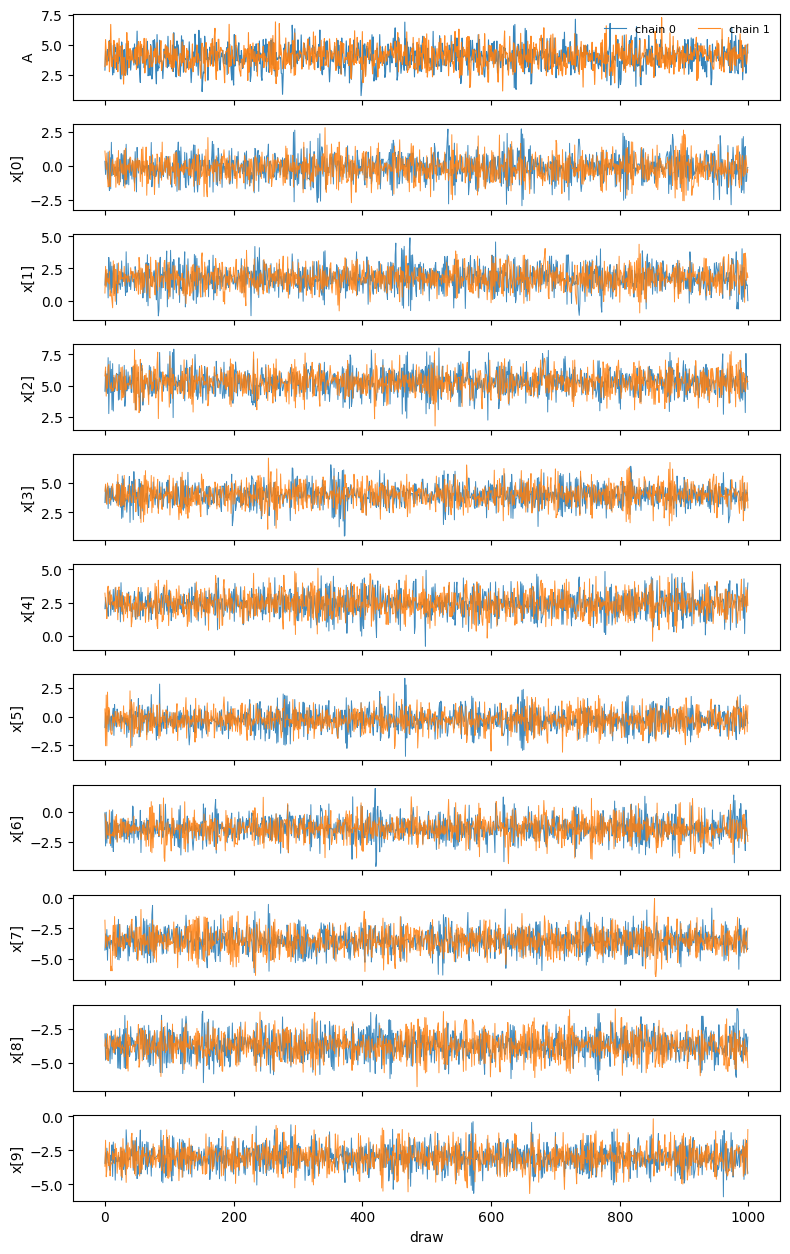

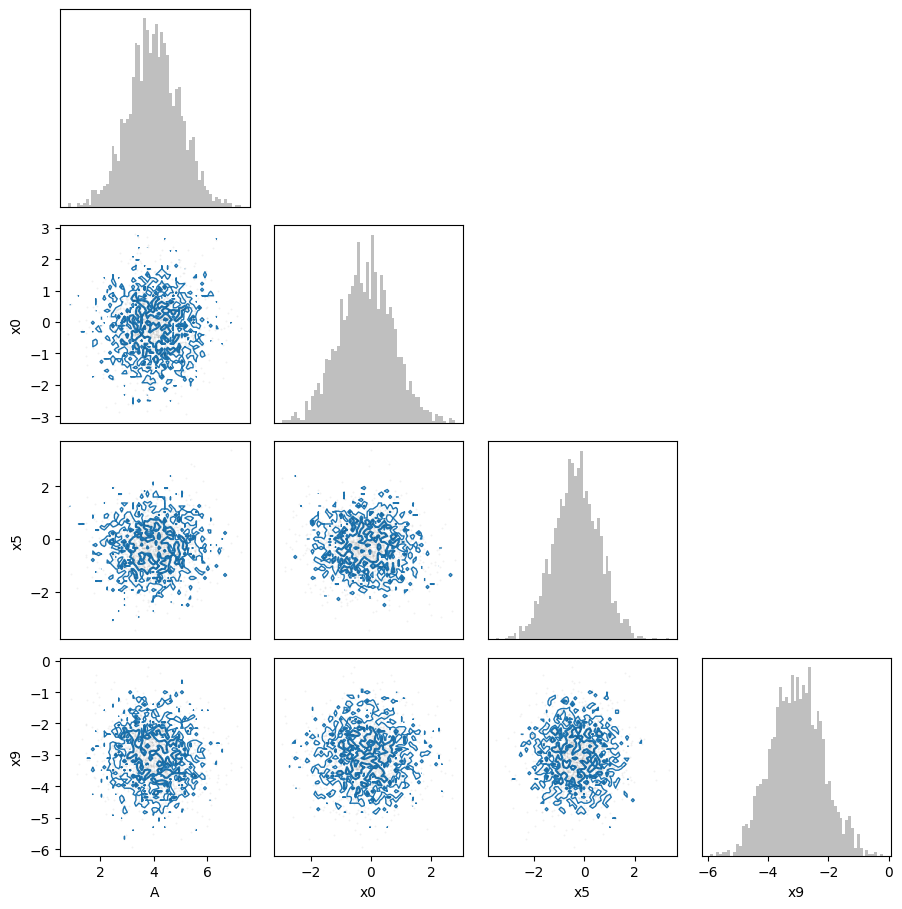

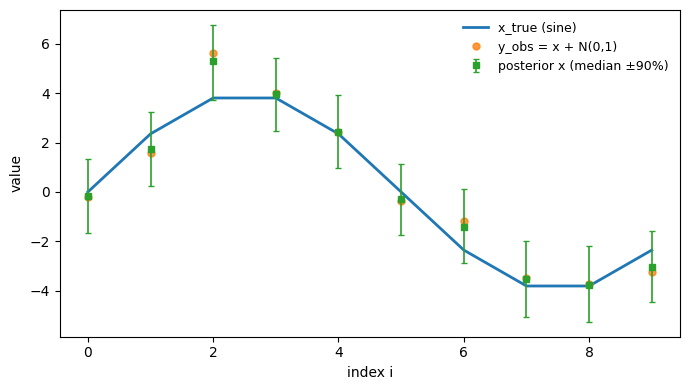

In [4]:
if JAX_ENABLE_X64:
    jax.config.update("jax_enable_x64", True)
numpyro.set_host_device_count(NUM_CHAINS)

# synthetic data: x_true is sine by index i; y = x_true + N(0,1)
i = jnp.arange(N)
x_true = TRUE_AMP * jnp.sin(2.0 * jnp.pi * i / N)
key = jax.random.key(SEED)
y_obs = x_true + NOISE_SIGMA * jax.random.normal(key, shape=(N,))

if MC_METHOD == "HMC":
    kernel = HMC(
        model,
        num_steps=HMC_NUM_STEPS,
        target_accept_prob=HMC_TARGET_ACCEPT_PROB,
        adapt_step_size=True,
        adapt_mass_matrix=True,
    )
elif MC_METHOD == "NUTS":
    kernel = NUTS(
        model,
        target_accept_prob=HMC_TARGET_ACCEPT_PROB, 
        adapt_step_size=True,
        adapt_mass_matrix=True,
    )
else:
    raise ValueError(f"Invalid MCMC method: {MC_METHOD}")

mcmc = MCMC(
    kernel,
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    progress_bar=True,
)
mcmc.run(jax.random.key(SEED + 1), y_obs=y_obs)

mcmc = MCMC(kernel, num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS, progress_bar=True)
mcmc.run(jax.random.key(SEED + 1), y_obs=y_obs)

post_by_chain = mcmc.get_samples(group_by_chain=True)
A_chain = np.asarray(post_by_chain["A"])  # (C,S)
x_chain = np.asarray(post_by_chain["x"])  # (C,S,N)
diag = summary({"A": A_chain, "x": x_chain}, group_by_chain=True)

# concise convergence printout
A_stats = diag["A"]
x_stats = diag["x"]
print(
    "\nConvergence: r_hat max =",
    float(np.nanmax(np.asarray(x_stats["r_hat"]))),
    " | n_eff min =",
    float(np.nanmin(np.asarray(x_stats["n_eff"]))),
)
print(f"Posterior A: mean={float(A_stats['mean']):.3f} ± {float(A_stats['std']):.3f}  r_hat={float(A_stats['r_hat']):.3f}")
print("Posterior x mean±sd:")
for k in range(N):
    print(f"  x[{k:02d}] = {x_stats['mean'][k]: .3f} ± {x_stats['std'][k]: .3f}   (y={float(y_obs[k]): .3f})")

# plots
post_flat = mcmc.get_samples(group_by_chain=False)
x_flat = np.asarray(post_flat["x"])  # (S,N)
plot_traces(A_chain, x_chain, "hmc_trace.png")
contour_samples = {"A": np.asarray(post_flat["A"])}
for k in PAIR_IDXS:
    contour_samples[f"x{k}"] = x_flat[:, k]
plot_contours(contour_samples, ["A"] + [f"x{k}" for k in PAIR_IDXS], "hmc_contours.png")
plot_fit(x_true, y_obs, x_flat, "hmc_fit.png")
plt.show()
